In [101]:
#Benchmarking Variational Quantum State Diagonalization Algorithm

In [1]:
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [40]:
# = 2
#n = 2*m
def test_prep(param):
    for i in range(2*len(param)):
        qml.Hadamard(i)
#    return [qml.expval(qml.PauliZ(i)) for i in range(2*m)]
drawer = qml.draw(test_prep)
print(drawer([0,1]))
#test_prep(m)

0: ──H─┤  
1: ──H─┤  
2: ──H─┤  
3: ──H─┤  


In [41]:
#TODO
#Make angles equal in the ith subsystem of registers 1 and 2
#param needs to be specifiable with m angles
#param = [0, 1, 2, 3]

def ansatz(param):
    for i in range(len(param)):
        qml.RZ(param[i], wires = i)
        qml.RZ(param[i], wires = i+len(param))
        qml.RX(np.pi/2, wires = i)
        qml.RX(np.pi/2, wires = i+len(param))
drawer = qml.draw(ansatz)
print(drawer([0,1]))

0: ──RZ(0.00)──RX(1.57)─┤  
2: ──RZ(0.00)──RX(1.57)─┤  
1: ──RZ(1.00)──RX(1.57)─┤  
3: ──RZ(1.00)──RX(1.57)─┤  


In [43]:
def cost_fun(param):
    for i in range(len(param)):
        qml.CNOT(wires = [i,i+len(param)])
drawer = qml.draw(cost_fun)
print(drawer([0,1]))

0: ─╭●─┤  
2: ─╰X─┤  
1: ─╭●─┤  
3: ─╰X─┤  


In [51]:
s = 1000
m = 2
n = 2*m
dev = qml.device("default.qubit", wires = 8, shots = s)
@qml.qnode(dev, interface = "autograd")
def circuit(param):
    test_prep(param)
    ansatz(param)
    cost_fun(param)
    return qml.probs(wires = [i for i in range(2*m)])

In [49]:
def VQSD(param):
    return -circuit(param)[0]

In [46]:
t = []
for i in range(n):
    t.append(0.0)
theta = np.array(t, requires_grad=True)
print(theta)

[0. 0. 0. 0.]


In [52]:
diag = [VQSD(theta)]
print(diag)

[-0.059]


In [25]:
# store the values of the circuit parameter
angle = [theta]
print(angle)
#len(angle)

[tensor([ 2.00000000e-04, -2.40000000e-03,  2.20000000e-03,
        -2.22044605e-20], requires_grad=True)]


In [36]:
###To Do
#Figure out why the energy stays roughly constant

opt = qml.GradientDescentOptimizer(stepsize=0.2)
max_iterations = 1000
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_diag = opt.step_and_cost(VQSD, theta)

    diag.append(VQSD(theta))
    angle.append(theta)

    conv = np.abs(diag[-1] - prev_diag)

    if n % 2 == 0:
        print(f"Step = {n},  Diagonality = {diag[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

#print("\n" f"Final value of the ground-state energy = {diag[-1]:.8f} Ha")
#print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Diagonality = 0.06700000 Ha
Step = 2,  Diagonality = 0.05900000 Ha
Step = 4,  Diagonality = 0.05700000 Ha
Step = 6,  Diagonality = 0.05900000 Ha
Step = 8,  Diagonality = 0.05400000 Ha
Step = 10,  Diagonality = 0.06000000 Ha
Step = 12,  Diagonality = 0.06500000 Ha
Step = 14,  Diagonality = 0.06800000 Ha
Step = 16,  Diagonality = 0.08400000 Ha
Step = 18,  Diagonality = 0.06700000 Ha
Step = 20,  Diagonality = 0.05200000 Ha
Step = 22,  Diagonality = 0.06200000 Ha
Step = 24,  Diagonality = 0.06400000 Ha
Step = 26,  Diagonality = 0.06200000 Ha
Step = 28,  Diagonality = 0.06300000 Ha
Step = 30,  Diagonality = 0.05600000 Ha
Step = 32,  Diagonality = 0.05600000 Ha
Step = 34,  Diagonality = 0.06500000 Ha
Step = 36,  Diagonality = 0.05000000 Ha
Step = 38,  Diagonality = 0.05200000 Ha
Step = 40,  Diagonality = 0.07900000 Ha
Step = 42,  Diagonality = 0.05900000 Ha
Step = 44,  Diagonality = 0.06600000 Ha
Step = 46,  Diagonality = 0.06700000 Ha
Step = 48,  Diagonality = 0.06500000 Ha
Step 

ValueError: x and y must have same first dimension, but have shapes (28,) and (38,)

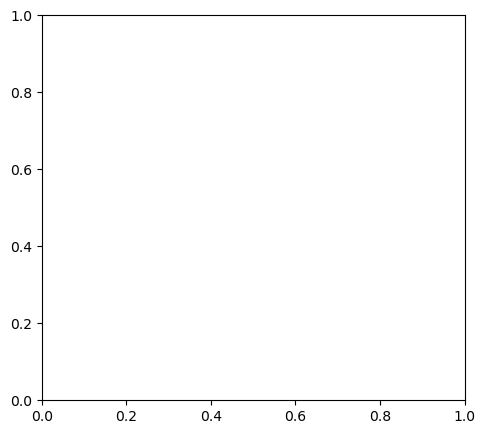

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), diag, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

In [31]:
angle

[tensor([ 2.00000000e-04, -2.40000000e-03,  2.20000000e-03,
         -2.22044605e-20], requires_grad=True),
 tensor([ 0.0028, -0.003 ,  0.0028, -0.0014], requires_grad=True),
 tensor([ 0.0036, -0.0018,  0.0008,  0.0006], requires_grad=True),
 tensor([ 0.0042, -0.0028, -0.0014,  0.0016], requires_grad=True),
 tensor([ 0.0028, -0.0046, -0.0004,  0.004 ], requires_grad=True),
 tensor([ 0.0038, -0.0026, -0.0026,  0.0036], requires_grad=True),
 tensor([ 0.001 , -0.0058, -0.0064,  0.0022], requires_grad=True),
 tensor([ 0.0042, -0.0032, -0.0038, -0.0006], requires_grad=True),
 tensor([ 0.0072, -0.0024, -0.0048,  0.004 ], requires_grad=True),
 tensor([ 0.0072, -0.0034, -0.0014,  0.009 ], requires_grad=True),
 tensor([ 0.0052, -0.0012, -0.0008,  0.009 ], requires_grad=True),
 tensor([ 6.00000000e-03, -3.20000000e-03,  8.34835673e-18,
          1.10000000e-02], requires_grad=True),
 tensor([5.60000000e-03, 6.07153217e-18, 2.00000000e-03, 1.06000000e-02], requires_grad=True),
 tensor([ 0.0038, -

In [32]:
diag

[0.059,
 0.074,
 0.065,
 0.06,
 0.061,
 0.06,
 0.06,
 0.047,
 0.073,
 0.062,
 0.061,
 0.052,
 0.061,
 0.055,
 0.062,
 0.063,
 0.058,
 0.051,
 0.052,
 0.086,
 0.072,
 0.06,
 0.057,
 0.051,
 0.057,
 0.08,
 0.063,
 0.068,
 0.067,
 0.067,
 0.069,
 0.057,
 0.06,
 0.065,
 0.07,
 0.059,
 0.067,
 0.067]

In [33]:
len(diag)

38

In [34]:
v = [0, 1, 2]
len(v)

3